In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import io
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint
from tensorflow.keras.models import load_model,save_model
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.applications import EfficientNetB0

In [3]:
X = []
Y = []
size = 150

train_im = 'C:/Users/Admin/PORTFOLIO/BrainTumorLearning/Brain-Tumor-Classification-DataSet-master/Training'
labels = os.listdir(train_im)
print(labels)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
# Will append all the images and their corresponding labels to an array,
# both the testing and training values
X = []
Y = []


for i in labels:
    fldr = os.path.join("C:/Users/Admin/PORTFOLIO/BrainTumorLearning/Brain-Tumor-Classification-DataSet-master","Training",i)
    for j in tqdm(os.listdir(fldr)):
        img = cv2.imread(os.path.join(fldr,j))
        img = cv2.resize(img,(size,size))
        X.append(img)
        Y.append(i)


100%|██████████| 827/827 [00:02<00:00, 358.70it/s]


In [5]:
# Repeats the same process for 
for i in labels:
    fldr = os.path.join("C:/Users/Admin/PORTFOLIO/BrainTumorLearning/Brain-Tumor-Classification-DataSet-master","Testing",i)
    for j in tqdm(os.listdir(fldr)):
        img = cv2.imread(os.path.join(fldr,j))
        img = cv2.resize(img,(size,size))
        X.append(img)
        Y.append(i)


100%|██████████| 74/74 [00:00<00:00, 190.70it/s]


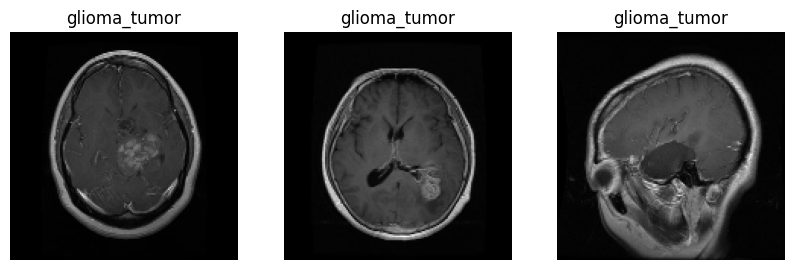

In [6]:
_,fig = plt.subplots(1,3,figsize = (10,10))
for ax,image,label in zip(fig,X,Y):
    ax.set_axis_off()
    ax.imshow(image,cmap=plt.cm.gray_r)
    ax.set_title(label)

In [7]:
# Converts our normal array into a numpy array 
X = np.array(X)
Y = np.array(Y)

In [8]:
# We randomize our data
X, Y = shuffle(X,Y,random_state=42)

X.shape

(3264, 150, 150, 3)

In [9]:
# Okay now we split our data into testing and training, with a training size of 80% and a test size of 20% 
x_train, x_test, y_train,y_test = train_test_split(X,Y,test_size=.2,random_state=33)

In [10]:
# We perform One Hot Encodding on our labels after converting them into numbers

Y_new_train = []
# Taking the labels from our training set we then correlte the label to its index from the array
# and save it into Y_new
for i in y_train:
    Y_new_train.append(labels.index(i))
y_train = Y_new_train
y_train = tf.keras.utils.to_categorical(y_train)


In [11]:
print(y_train)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [12]:
# Now we do the same for our testing labels
Y_new_test = []
# Taking the labels from our testing set we then correlte the 
# label to its index from the array and save it into Y_new
for i in y_test:
    Y_new_test.append(labels.index(i))
y_test = Y_new_test
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
# We are gonna use transfer learning as it uses less computation power
# than deep learning and its more efficient too. We first import a pre-built model
# to build our model on top
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(size,size,3))

In [14]:
tumor_model = effnet.output

tumor_model = tf.keras.layers.GlobalAveragePooling2D()(tumor_model)

tumor_model = tf.keras.layers.Dropout(rate=.5)(tumor_model)

tumor_model = tf.keras.layers.Dense(4,activation='softmax')(tumor_model)

tumor_model = tf.keras.models.Model(inputs = effnet.input,outputs = tumor_model)

In [15]:
tumor_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [16]:
tumor_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
tensorboard = TensorBoard(log_dir = "logs")

checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode = "auto",verbose = 1,save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor= "val_accuracy",factor=.3,patience=2,min_delta=.001,mode="auto",verbose=1)



In [18]:

history = tumor_model.fit(x_train,y_train,validation_split=0.1, epochs =6, verbose=1, batch_size=32,callbacks=[tensorboard,checkpoint,reduce_lr])


Epoch 1/6
74/74 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.8203
Epoch 1: val_accuracy improved from -inf to 0.81298, saving model to effnet.h5
74/74 [==============================] - 139s 2s/step - loss: 0.4851 - accuracy: 0.8203 - val_loss: 0.5891 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 2/6
74/74 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9315
Epoch 2: val_accuracy improved from 0.81298 to 0.88931, saving model to effnet.h5
74/74 [==============================] - 128s 2s/step - loss: 0.2096 - accuracy: 0.9315 - val_loss: 0.4186 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 3/6
74/74 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.9570
Epoch 3: val_accuracy did not improve from 0.88931
74/74 [==============================] - 129s 2s/step - loss: 0.1163 - accuracy: 0.9570 - val_loss: 0.6638 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 4/6
74/74 [==============================] - ETA: 0s - loss: 0.1456 - accu

In [19]:
# tumor_model= load_model("C:/Users/Admin/PORTFOLIO/BrainTumorLearning/model_weights.h5")

In [20]:
classified_labels = tumor_model.predict(x_test)
classified_labels = np.argmax(classified_labels,axis=1)

y_test_new = np.argmax(y_test,axis=1)

21/21 [==============================] - 9s 397ms/step


In [21]:
print(metrics.classification_report(y_test_new,classified_labels))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       201
           1       0.92      0.96      0.94       174
           2       0.91      1.00      0.96        96
           3       1.00      0.95      0.97       182

    accuracy                           0.96       653
   macro avg       0.95      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



In [22]:
print(metrics.confusion_matrix(classified_labels,y_test_new))

[[190   4   0   0]
 [  8 167   0   7]
 [  3   3  96   3]
 [  0   0   0 172]]


In [23]:
tumor_model.save_weights("model_weights.h5")